# Initialization

In [1]:
\c 5 100
h:`$":tpr-mscf-kx.tepper.cmu.edu:5000:mscf2023:LZ8AByXHDaEJdTim"

In [2]:
/%python
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

plt.style.use('default')

In [3]:
/%python 

#you may want to install tensorflow if you don't have it currently (uncomment following line and run cell)
#!pip install tensorflow 

In [3]:
/ split date
train_test_split_date: 2020.02.10

In [28]:
/%python 
#set random seed for reproductability
train_test_split_date = '2020-02-10'
tensorflow.random.set_seed(15451)
np.random.seed(15451)


# Load Data

In [4]:
loaddata:{[s;c;sd;ed]
 / YOUR CODE HERE
 t:select date,sym,time,price,size from trade where date within (sd;ed), sym in s, cond in c;
 t}

/ we are set to use the spy data from trade dataframe 
show t_save:h (loaddata;`SPY;" ";2020.02.01;2020.03.01)

date       sym time                 price  size
-----------------------------------------------
2020.02.03 SPY 0D09:30:00.003121564 323.35 400 
2020.02.03 SPY 0D09:30:00.003130283 323.35 500 
2020.02.03 SPY 0D09:30:00.003189672 323.35 500 
2020.02.03 SPY 0D09:30:00.003257331 323.35 500 
2020.02.03 SPY 0D09:30:00.020404742 323.35 377 
..


We take all days before split date to train the model, take one day as testing date

In [5]:
train_data: select from t_save where date < train_test_split_date
test_data: select from t_save where date = train_test_split_date

# Prediction of Price in 30s interval

In [6]:
/ aggregate the model into 30 seconds interval, for each second, compute its mean order price. 
/ Fill missing seconds with previous second's mean order price 
get_features:{[t]
 // return the average price and sum of trading sizes within the given time step
 // no need to do symbol cuz its just spy 
 x_sec: `date xasc select price:(sum (price*size))%sum size,size:sum size by date, time.second from t;

 keytable: key x_sec;
 dates: raze 23401#/:distinct keytable[`date];
 times: 09:30:00 + til (23401);
 times: raze 5#enlist times;
 n:count times;
 x_sec_nan:([date:dates; second:times];price:n#0n; size:n#0n);
 x_sec_nan: `date xasc select from x_sec_nan;

 x_sec: aj[`date`second;x_sec_nan;x_sec];
 x_sec: `date`second xasc select price, size by date, 30 xbar second from x_sec;
 x_sec}

dfs_train: get_features[train_data]
x_sec_train: get_features[train_data]

In [7]:
/% take a look at the df
x_sec_train

date       second  | price                                                                       ..
-------------------| ----------------------------------------------------------------------------..
2020.02.03 09:30:00| 323.349  323.3316 323.2961 323.3162 323.2817 323.3136 323.3208 323.3305 323...
2020.02.03 09:30:30| 323.6133 323.5983 323.5907 323.5802 323.58   323.6071 323.6439 323.6405 323...
2020.02.03 09:31:00| 323.7415 323.7377 323.7147 323.7437 323.7661 323.7589 323.737  323.7321 323...
2020.02.03 09:31:30| 323.751  323.7823 323.7733 323.7502 323.7351 323.715  323.7181 323.7248 323...
2020.02.03 09:32:00| 323.819  323.8015 323.7797 323.7647 323.7527 323.7409 323.7188 323.7113 323...
..


In [8]:
/% convert to pd df 
tab2df:{r:.p.import[`pandas; `:DataFrame; x][@; cols x];$[count k:keys x; r[`:set_index]k; r]}
.p.set[`x_sec_train] tab2df x_sec_train

In [9]:
/%python
print(x_sec_train.reset_index().head())

   date  ...                                               size
0  7338  ...  [10295, 16685, 2731, 5754, 2100, 7730, 4300, 5...
1  7338  ...  [4295, 2959, 4000, 900, 500, 700, 2172, 1397, ...
2  7338  ...  [10326, 3407, 2980, 6145, 16701, 11860, 6600, ...
3  7338  ...  [4600, 4904, 922, 5738, 1484, 100, 3612, 370, ...
4  7338  ...  [1459, 2000, 2900, 816, 1100, 6986, 3000, 1193...

[5 rows x 4 columns]


so now for each entry in the dataframe, it contains 30 seconds' (average price per second). 
We learn a model that takes first 29 seconds and predict last 1 second's average price 

In [10]:
/%python
# reset index here so that we split the tuple keys  
x_sec_train = x_sec_train.reset_index()

Create train function by using first 29 seconds as train sample, last second as prediction step (1 step prediction)
Note that we do not suffle the data so that even in training process it is fed into the model in timely order

In [11]:
/%python
X_train, y_train = [], []
count = 0
for i in range(len(x_sec_train)):
    p = list(x_sec_train.price[i])
    try:
        y_train.append(p[29])
        X_train.append(p[:29])
    except:
        count += 1
X_train, y_train = np.array(X_train), np.array(y_train)

The ending second (exactly at 4p.m.) is nan because it does not have exactly 30 time stamps (1 instead, which is what we actually wanted to predict)

In [12]:
/%python
print(len(x_sec_train), count)
print(X_train.shape, y_train.shape)

3905 5
(3900, 29) (3900,)


We did not do model selection/hyperparameter tuning due to time constraint

In [15]:
/%python
model = Sequential()
# 64 is dimension of the model 
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)))
# dense 1 for one-step ahead prediction 
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mse')

In [16]:
/%python
model.fit(X_train,y_train,epochs=5, batch_size=32)

Epoch 1/5
122/122 [==============================] - 1s 4ms/step - loss: 6913.4009
Epoch 2/5
122/122 [==============================] - 0s 4ms/step - loss: 0.0448
Epoch 3/5
122/122 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 4/5
122/122 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 5/5
122/122 [==============================] - 0s 4ms/step - loss: 0.0019


## Inference

In [17]:
/ aggregate the model into 30 seconds interval
get_features:{[t]
 // return the average price and sum of trading sizes within the given time step
 // no need to do symbol cuz its just spy 
 x_sec: `date xasc select price:(sum (price*size))%sum size,size:sum size by date, time.second from t;

 keytable: key x_sec;
 a: count distinct keytable[`date];
 dates: raze 23401#/:distinct keytable[`date];
 times: 09:30:00 + til (23401);
 times: raze a#enlist times;
 n:count times;
 x_sec_nan:([date:dates; second:times];price:n#0n; size:n#0n);
 x_sec_nan: `date xasc select from x_sec_nan;

 x_sec: aj[`date`second;x_sec_nan;x_sec];
 x_sec: `date`second xasc select price, size by date, 30 xbar second from x_sec;
 x_sec}


x_sec_test: get_features[test_data]

In [18]:
.p.set[`x_sec_test] tab2df x_sec_test
x_sec_test

date       second  | price                                                                       ..
-------------------| ----------------------------------------------------------------------------..
2020.02.10 09:30:00| 331.2532 331.2852 331.3175 331.279  331.2561 331.2627 331.2621 331.26   331...
2020.02.10 09:30:30| 331.5079 331.48   331.4668 331.47   331.47   331.436  331.4067 331.4156 331...
2020.02.10 09:31:00| 331.3167 331.3333 331.3707 331.4056 331.4152 331.3742 331.3617 331.3506 331...
2020.02.10 09:31:30| 331.3979 331.396  331.4    331.3953 331.3921 331.4003 331.43   331.41   331...
2020.02.10 09:32:00| 331.5373 331.5833 331.5984 331.6042 331.5736 331.5983 331.6    331.61   331...
..


In [19]:
/%python
x_sec_test = x_sec_test.reset_index()

Drop the last second as explained before

In [24]:
/%python 
x_sec_test = x_sec_test.drop(x_sec_test.index[-1])

In [25]:
/%python
X_test, y_test = [], []
count = 0
for i in range(len(x_sec_test)):
    p = list(x_sec_test.price[i])
    try:
        y_test.append(p[29])
        X_test.append(p[:29])
    except:
        count += 1
X_test, y_test = np.array(X_test), np.array(y_test)

In [26]:
/%python
predictions = model.predict(X_test)

25/25 [==============================] - 0s 1ms/step


extract predictions and create an prediction vs actual plot

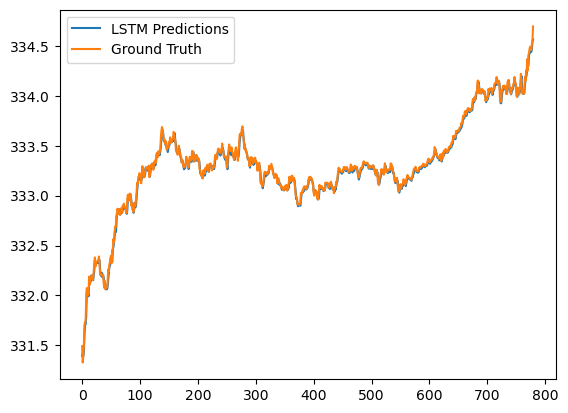

In [27]:
/%python
predictions = [i[0] for i in predictions]
import matplotlib.pyplot as plt
plt.plot(predictions, label='LSTM Predictions')
plt.plot(y_test, label='Ground Truth')
plt.legend()
plt.show()

## Extract result

The resulting dataframe has two columns (time, t and prediction, p)
at the same row, prediction p indicates the predicted price based on the information of 29 seconds starting from
time t

In [35]:
/%python
# Specify the date
start_date = train_test_split_date

# Specify the start and end times
start_time = '09:30:00'
end_time = '16:00:00'

# Create a DatetimeIndex with 30-second frequency
time_range = pd.date_range(start=f'{start_date} {start_time}', end=f'{start_date} {end_time}', freq='30S')

# Create a pandas Series with the time range
time_series = pd.Series(time_range)[:-1]

df = pd.DataFrame({'Time': time_series, 'Prediction': predictions})

print(df.head())

                 Time  Prediction
0 2020-02-10 09:30:00  331.394135
1 2020-02-10 09:30:30  331.417236
2 2020-02-10 09:31:00  331.392273
3 2020-02-10 09:31:30  331.436249
4 2020-02-10 09:32:00  331.605438
